In [16]:
!pip install --upgrade albumentations -q


import os
import pandas as pd
import pickle
import shutil
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import ImageFile
import glob
import shutil
import cv2

from sklearn.datasets import load_files
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image  

import albumentations as A
from tensorflow.keras.models import Model
import tensorflow.keras.layers
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model

In [2]:
def draw_plot_from_history(history, metric, n_epochs, stage):
    plt.style.use("ggplot")
    plt.figure(figsize=(9, 5))
    plt.plot(np.arange(0, n_epochs), history.history[metric], label="train_%s" % metric)
    if "val_%s" % metric in history.history:
        plt.plot(np.arange(0, n_epochs), history.history["val_%s" % metric], label="val_%s" % metric)
    title = stage + '_%s' % metric
    plt.title(title)
    plt.xlabel("Epoch #")
    plt.ylabel("Value")
    plt.legend()
    filename = title + '.png'
    plt.show()

In [17]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size, augmentation, image_size, shuffle=True):
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.shuffle = shuffle
        self.image_size = image_size

        self.image_names = np.array([item['path'] for item in data])
        self.targets = to_categorical(np.array([int(item['label'][1:]) for item in data]))
        self.samples = len(self.targets)

        self.indexes = np.arange(self.samples)
        if shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(self.samples / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def transform_image(self, image):
        image = cv2.resize(image, (self.image_size, self.image_size), interpolation = cv2.INTER_CUBIC)

        if self.augmentation:
            image = self.augmentation(image=image)['image']

        return image

    def __getitem__(self, index):
        take_ind = self.indexes[index * self.batch_size: min((index + 1) * self.batch_size, len(self.targets))]
        X = np.empty((len(take_ind), self.image_size, self.image_size, 3))
        y = self.targets[take_ind, :]

        for i in range(len(take_ind)):
            img = cv2.imread(self.image_names[take_ind[i]], cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = self.transform_image(img)
            X[i] = img
            
        X = preprocess_input(X)

        return X, y

Create augmentations:

In [18]:
transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, 
                           p=0.5, border_mode=cv2.BORDER_CONSTANT), 
        A.RandomBrightnessContrast(p=0.5),
        A.RGBShift(p=0.25),
        A.GaussNoise(p=0.25),
        A.HorizontalFlip(p=0.5),
    ]
)

Create generators:

In [19]:
TRAIN_DIR = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train"
TEST_DIR = "/kaggle/input/state-farm-distracted-driver-detection/imgs/test"

In [20]:
INPUT_SHAPE = 224
BATCH_SIZE = 32
num_classes = 10

In [21]:
train_data = []
label_stat = []

for label in os.listdir(TRAIN_DIR):
    for img_path in glob.glob(os.path.join(TRAIN_DIR, label, "*.jpg")):
        train_data.append({'path': img_path, 'label': label})
        label_stat.append(label)

train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=label_stat, shuffle=True)

train_generator = DataGenerator(train_data, BATCH_SIZE, transform, INPUT_SHAPE)
validation_generator = DataGenerator(val_data, BATCH_SIZE, None, INPUT_SHAPE, shuffle=False)

Build model:

In [22]:
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(INPUT_SHAPE, INPUT_SHAPE, 3))
for layer in model.layers:
    layer.trainable = False

x = model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

9412608/9406464 [==============================] - 0s 0us/step


In [8]:
# model = Sequential()
# model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(INPUT_SHAPE, INPUT_SHAPE, 3)))
# model.add(BatchNormalization())
# model.add(Conv2D(64, kernel_size=3, activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Conv2D(128, kernel_size=3, activation='relu'))
# model.add(BatchNormalization())
# model.add(GlobalAveragePooling2D())
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(10, activation='softmax'))
# print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 220, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 108, 108, 128)     5

Warmup:

In [23]:
NUM_EPOCHS = 3
LEARNING_RATE = 0.001

Epoch 1/3
560/560 [==============================] - 315s 559ms/step - loss: 1.8362 - accuracy: 0.3728 - val_loss: 0.7831 - val_accuracy: 0.7853
Epoch 2/3
560/560 [==============================] - 198s 353ms/step - loss: 0.9787 - accuracy: 0.6831 - val_loss: 0.5820 - val_accuracy: 0.8469
Epoch 3/3
560/560 [==============================] - 190s 339ms/step - loss: 0.8567 - accuracy: 0.7207 - val_loss: 0.4745 - val_accuracy: 0.8685


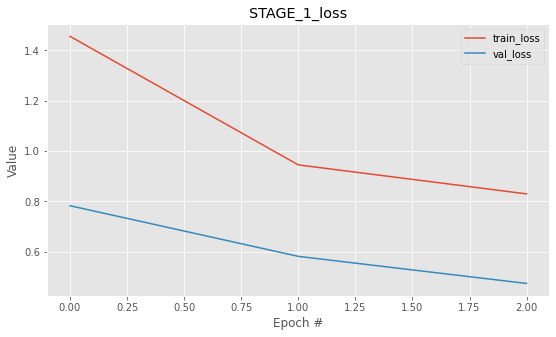

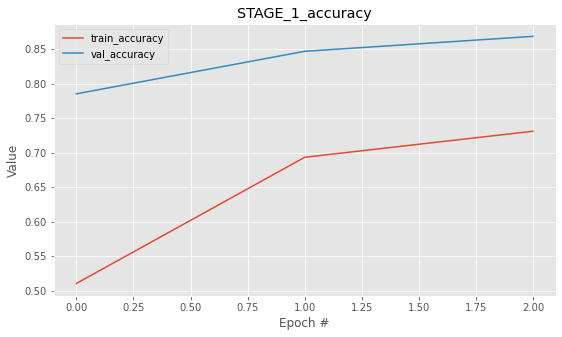

In [24]:
opt = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs=NUM_EPOCHS, verbose=1)

draw_plot_from_history(history, 'loss', NUM_EPOCHS, 'STAGE_1')
draw_plot_from_history(history, 'accuracy', NUM_EPOCHS, 'STAGE_1')

In [25]:
model.save("model3_stage1.hdf5")

Unfreezeing deeper layers:

In [26]:
NUM_EPOCHS = 30
LEARNING_RATE = 0.0003
FINE_TUNE_FROM_LAYER = -20

In [27]:
for layer in model.layers:
    layer.trainable = False
for layer in model.layers[FINE_TUNE_FROM_LAYER:]:
    if not isinstance(layer, tensorflow.keras.layers.BatchNormalization):
        layer.trainable = True

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
560/560 [==============================] - 195s 345ms/step - loss: 1.2893 - accuracy: 0.5932 - val_loss: 0.2128 - val_accuracy: 0.9292

Epoch 00001: val_loss improved from inf to 0.21278, saving model to model3_stage2.hdf5
Epoch 2/30
560/560 [==============================] - 190s 340ms/step - loss: 0.3121 - accuracy: 0.9011 - val_loss: 0.2100 - val_accuracy: 0.9297

Epoch 00002: val_loss improved from 0.21278 to 0.20997, saving model to model3_stage2.hdf5
Epoch 3/30
560/560 [==============================] - 189s 338ms/step - loss: 0.1900 - accuracy: 0.9371 - val_loss: 0.0708 - val_accuracy: 0.9790

Epoch 00003: val_loss improved from 0.20997 to 0.07084, saving model to model3_stage2.hdf5
Epoch 4/30
560/560 [==============================] - 191s 341ms/step - loss: 0.1607 - accuracy: 0.9472 - val_loss: 0.0616 - val_accuracy: 0.9839

Epoch 00004: val_loss improved from 0.07084 to 0.06162, saving model to model3_stage2.hdf5
Epoch 5/30
560/560 [==============================] 

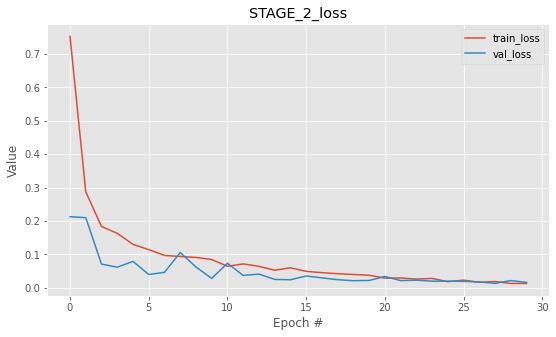

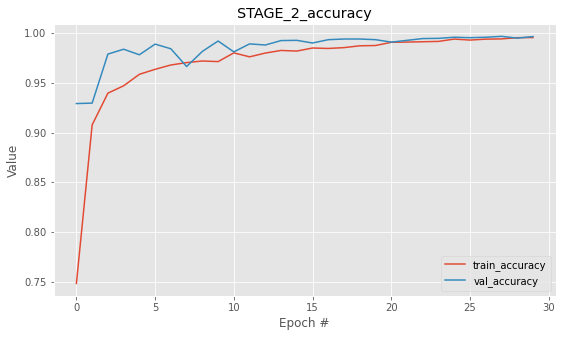

In [28]:
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=NUM_EPOCHS * train_generator.samples // BATCH_SIZE,
    end_learning_rate=LEARNING_RATE / 10,
    power=1.0)

opt = Adam(learning_rate=learning_rate_fn)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

save_best_checkpoint = ModelCheckpoint("model3_stage2.hdf5", verbose=1, monitor='val_loss', save_best_only=True, mode='auto')

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = NUM_EPOCHS,
    callbacks=[save_best_checkpoint], 
    verbose=1)

draw_plot_from_history(history, 'loss', NUM_EPOCHS, 'STAGE_2')
draw_plot_from_history(history, 'accuracy', NUM_EPOCHS, 'STAGE_2')

In [29]:
def save_plot_from_history(history, metric, n_epochs, stage):
    plt.style.use("ggplot")
    plt.figure(figsize=(21, 15))
    plt.plot(np.arange(0, n_epochs), history.history[metric], label="train_%s" % metric)
    if "val_%s" % metric in history.history:
        plt.plot(np.arange(0, n_epochs), history.history["val_%s" % metric], label="val_%s" % metric)
    title = metric
    plt.title(title, fontsize=18)
    plt.xlabel("Epoch #", fontsize=18)
    plt.ylabel("Value", fontsize=18)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    filename = title + '.png'
    plt.savefig(filename)

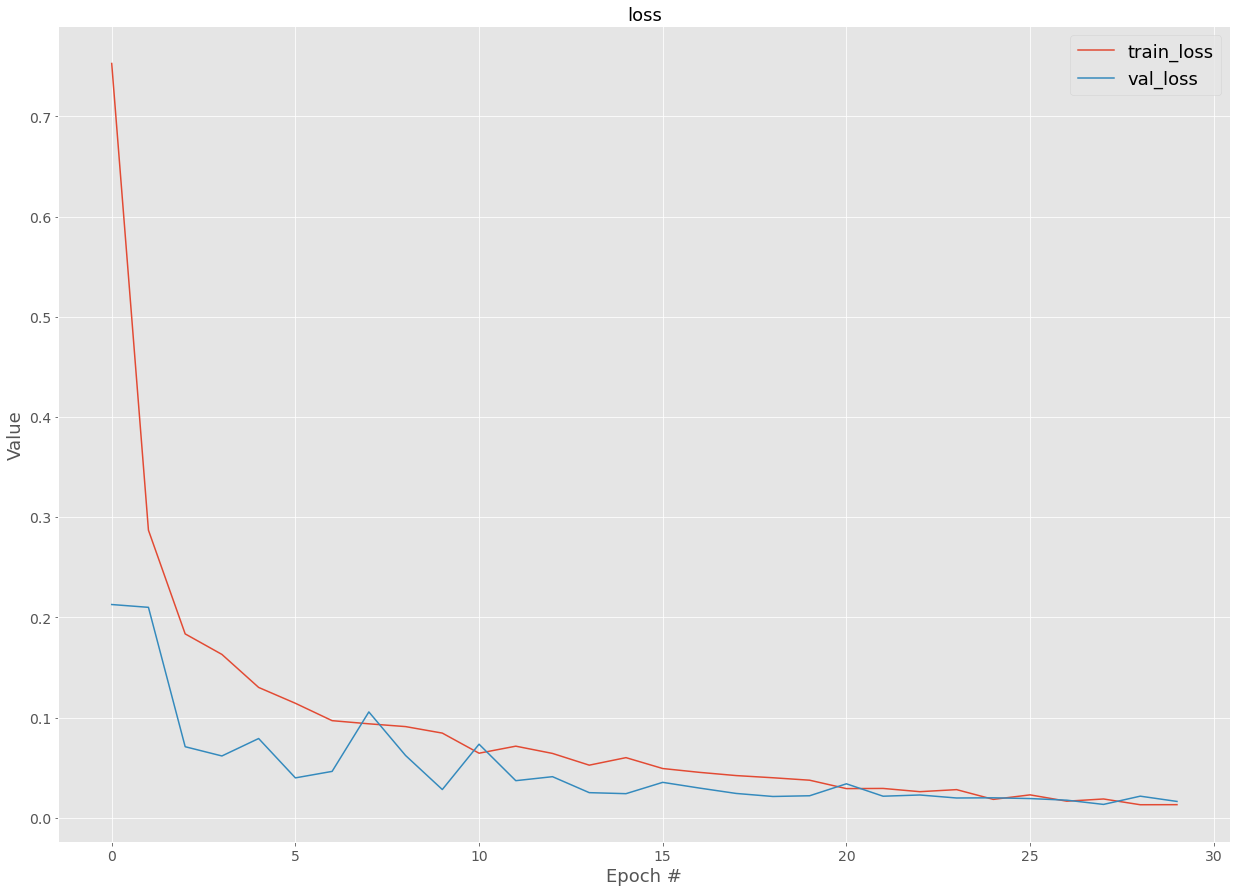

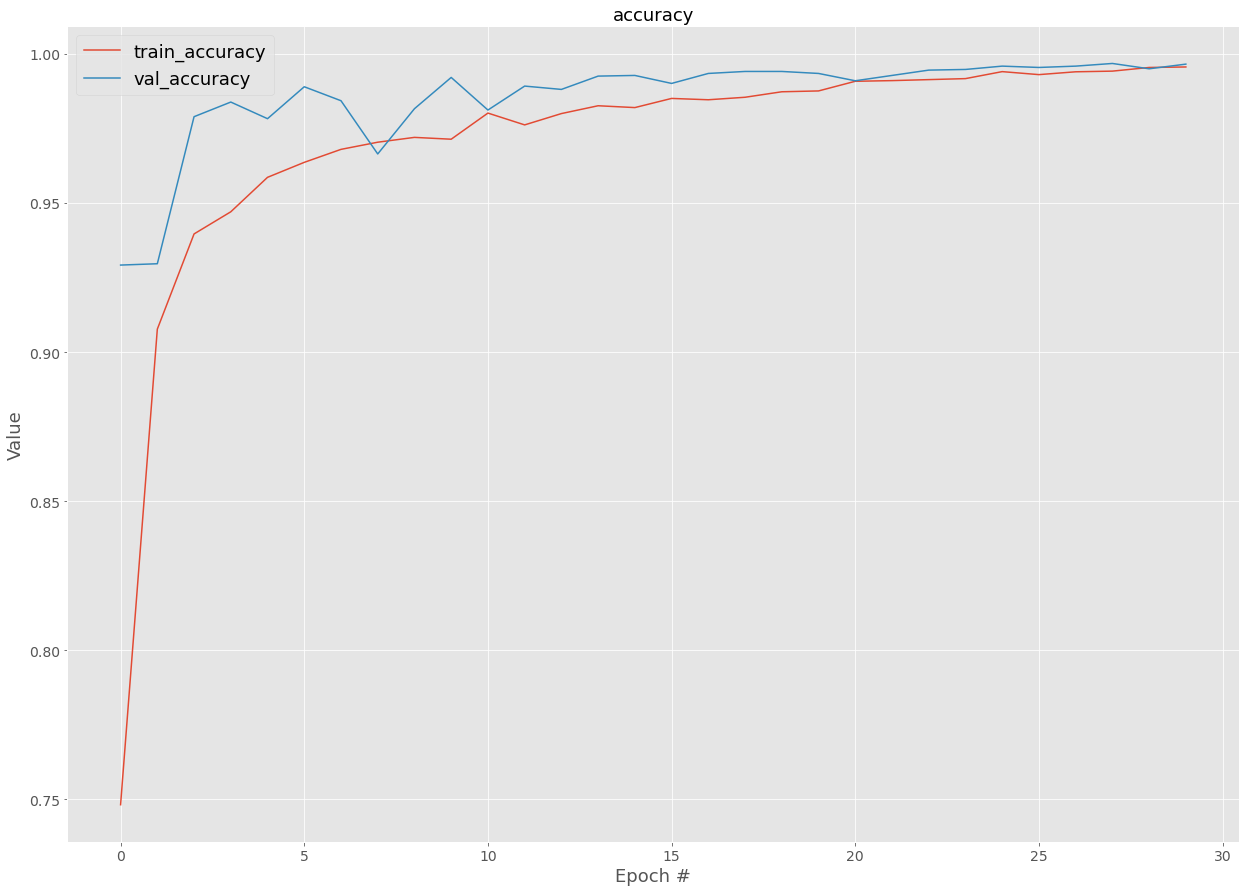

In [30]:
save_plot_from_history(history, 'loss', NUM_EPOCHS, 'STAGE_2')
save_plot_from_history(history, 'accuracy', NUM_EPOCHS, 'STAGE_2')

Make predictions:

In [31]:
from tqdm.auto import tqdm

In [32]:
def classify(model, test_img_dir):

    result = dict()
    keys = ['name', *['c%d' % i for i in range(10)]]
    for key in keys:
        result[key] = []
        
    paths = sorted(list(os.listdir(test_img_dir)))

    for path in tqdm(paths):
        if not path.endswith('.jpg'):
            continue
        
        image = cv2.imread(os.path.join(test_img_dir, path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (INPUT_SHAPE, INPUT_SHAPE), interpolation = cv2.INTER_CUBIC)

        pred = model.predict(np.expand_dims(image, 0))[0]
        result['name'].append(path)
        for i in range(10):
            result['c%d' % i].append(pred[i])

    return result

In [33]:
model = load_model('model3_stage2.hdf5')

In [34]:
result = classify(model, TEST_DIR)

  0%|          | 0/79726 [00:00<?, ?it/s]

In [35]:
dct = {'img': result['name']}
for i in range(10):
    col = 'c%d' % i
    dct[col] = result[col]
    
df = pd.DataFrame(dct)
df.to_csv('submission.csv', index=False)
df

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.062543,5.631151e-05,0.075739,0.001336,0.014931,0.481870,0.110698,0.001801,0.144129,0.106896
1,img_10.jpg,0.006375,2.414982e-06,0.018350,0.000093,0.001768,0.403393,0.305309,0.000603,0.135352,0.128754
2,img_100.jpg,0.118056,4.283812e-05,0.005740,0.000276,0.004418,0.225985,0.555873,0.018085,0.020436,0.051088
3,img_1000.jpg,0.000398,1.739449e-07,0.007015,0.000008,0.000342,0.834229,0.121368,0.000156,0.008021,0.028464
4,img_100000.jpg,0.004788,2.793460e-07,0.046994,0.000020,0.001501,0.032326,0.814953,0.016309,0.067636,0.015474
...,...,...,...,...,...,...,...,...,...,...,...
79721,img_99994.jpg,0.001525,6.175741e-05,0.212620,0.000342,0.013027,0.042359,0.477636,0.158420,0.058214,0.035797
79722,img_99995.jpg,0.000049,9.727305e-07,0.008905,0.000001,0.000121,0.000693,0.035109,0.903204,0.023294,0.028621
79723,img_99996.jpg,0.001199,4.151925e-07,0.323992,0.000008,0.000819,0.002493,0.506859,0.051473,0.104346,0.008810
79724,img_99998.jpg,0.000119,2.835315e-06,0.089199,0.000004,0.000237,0.026138,0.752992,0.001929,0.097717,0.031663


Improve score a bit with clipping hack:

In [36]:
df_new = df.copy()

cols = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
arr, names = df_new.values[:, 1:], df_new.values[:, 0]
arr = np.clip(arr, 0.025, 0.975)
arr /= np.sum(arr, axis=1, keepdims=True)

new_df = pd.DataFrame(np.hstack([names.reshape((-1, 1)), arr]), columns=df.columns)
new_df.to_csv('submission_new.csv', index=False)